# Homework (Week 3) -- Biometrics (15 points)

In this homework we train Biometrics Verification model and use some features to increase quality:
1) Train ECAPA-TDNN (5 points)
2) Contrastive or Triplet loss (5 points)
3) EER < 0.08 (5 point). Partial points for EER > 0.08  

Link to download dataset: https://disk.yandex.ru/d/lyhtieYbxQOYqw

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchaudio
import tqdm.notebook as tqdm
import urllib

import dataset

from IPython.display import clear_output

%matplotlib inline

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/lyhtieYbxQOYqw'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O voxceleb.tar.gz "{download_url}"
!tar -xf voxceleb.tar.gz

--2024-02-17 19:10:49--  https://downloader.disk.yandex.ru/disk/9a36c09c6aa94ea4c283d6e7e1a3c08847bca72bbce7027d7929aa41b9ad769d/65d112c9/gtj3WQiuHGabqHv6W0pVHNJIUgtSWTZDwbzsVe5DMplbs5asv2nBcD3Cqjp-J8909zgU-GpPeRE_lnRWKdcTVw%3D%3D?uid=0&filename=voxceleb.tar.gz&disposition=attachment&hash=UbepA8Q9HDxeFKWCa8Y0tO7K9asCmTAjTZtG1dex6z7oEbCbmS7yu53hGphcr8rhq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fx-gzip&owner_uid=163052607&fsize=10417995782&hid=f1790bd28373ce0f598cd14b8c76d6b8&media_type=compressed&tknv=v2
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|77.88.21.127|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s159vla.storage.yandex.net/rdisk/9a36c09c6aa94ea4c283d6e7e1a3c08847bca72bbce7027d7929aa41b9ad769d/65d112c9/gtj3WQiuHGabqHv6W0pVHNJIUgtSWTZDwbzsVe5DMplbs5asv2nBcD3Cqjp-J8909zgU-GpPeRE_lnRWKdcTVw==?uid=0&filename=voxceleb

### Some model train example

In [2]:
DEVICE = 'mps' # "cpu" for cpu, also you can use "cuda" for gpu and "mps" for apple silicon
DATADIR = 'data'
FEATS = 80
LOADER_WORKERS = 8

In [3]:
transform = torchaudio.transforms.MelSpectrogram(n_mels=FEATS)
trainset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_train'), transform)
testset = dataset.Dataset(os.path.join(DATADIR, 'voxceleb_test'), transform)
test_targets = pd.read_csv(os.path.join(DATADIR, 'target.csv')).values.tolist()

### Models

In [4]:
class Model(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden: int, kernel: int = 7, sride: int = 2):
        super().__init__()
        self._emb = nn.Sequential(
            nn.Conv1d(input_shape, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel, stride=sride),
            nn.AdaptiveMaxPool1d(1),
        )
        self._final = nn.Conv1d(hidden, output_shape, 1)

    def forward(self, X) -> tuple[torch.Tensor, torch.Tensor]:
        emb = self._emb(X)
        return self._final(emb), emb

### Metrics

Cosine similarity:
$CS(a, b) = \frac{<a, b>}{\|a\| \|b\|}$

In [5]:
def cosine_similarity(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

Here is O(N log N) algorithm for find best_eer:
1) Sort prediction by probability
2) Going through items and recalculating far and frr

In [6]:
def best_eer(data):
    full = sorted(data, key=lambda x: (x[0], -x[1]))
    pos = len([item for item in full if item[1] == 1])
    neg = len(full) - pos
    cur_pos = pos
    cur_neg = 0
    best_eer = 1
    for _, label in full:
        if label == 1:
            cur_pos -= 1
        else:
            cur_neg += 1
        cur_eer = max((pos - cur_pos) / pos, (neg - cur_neg) / neg)
        best_eer = min(best_eer, cur_eer)
    return best_eer

### Train

In [7]:
def train_stage(model, opt, batch_size: int = 256):
    loader = torch_data.DataLoader(
        trainset,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    loss_sum = 0.0
    batches = 0
    for X, Y, _ in tqdm.tqdm(loader):
        logits, _ = model.forward(X.to(DEVICE))
        loss = F.cross_entropy(logits, Y.to(DEVICE))
        loss_sum += loss.item()
        batches += 1
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss_sum / batches

In [8]:
def calc_eval_score(model: nn.Module, batch_size: int = 256):
    loader = torch_data.DataLoader(
        testset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        num_workers=LOADER_WORKERS,
    )
    items = {}
    target_scores = []
    with torch.no_grad():
        for X, _, pathes in tqdm.tqdm(loader):
            _, embds = model.forward(X.to(DEVICE))
            embds = embds.cpu().data.numpy().reshape(X.shape[0], -1)
            for embd, path in zip(embds, pathes):
                items[path] = embd
    for item1, item2, target in test_targets:
        target_scores.append((cosine_similarity(items[item1], items[item2]), target))
    return best_eer(target_scores)

In [9]:
def train(
    model: nn.Module,
    batch_size: int = 256,
    epochs: int = 10,
):
    opt = optim.Adam(model.parameters())
    train_losses = []
    eval_scores = []
    for epoch in range(epochs):
        model.train()
        train_losses.append(train_stage(model, opt, batch_size=batch_size))
        model.eval()
        eval_scores.append(calc_eval_score(model, batch_size=batch_size))
        clear_output()
        fig, axis = plt.subplots(1, 2, figsize=(15, 7))
        axis[0].plot(np.arange(1, epoch + 2), train_losses, label='train CE loss')
        axis[1].plot(np.arange(1, epoch + 2), eval_scores, label='eval')
        axis[0].set(xlabel='epoch', ylabel='CE Loss')
        axis[1].set(xlabel='epoch', ylabel='EER')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}. Train loss {train_losses[-1]}. Eval score {eval_scores[-1]}')

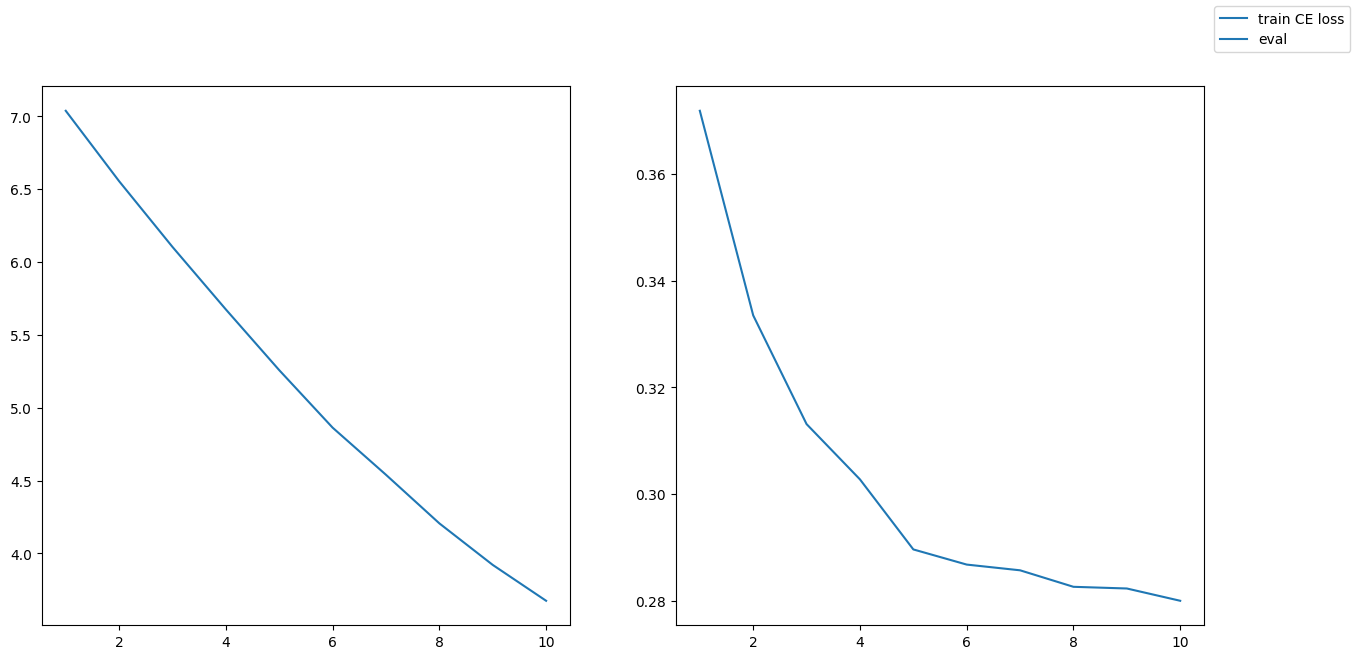

Epoch 10. Train loss 3.674928805513202. Eval score 0.27999237078008776


In [12]:
model = Model(FEATS, trainset.speakers(), 128).to(DEVICE)
train(model)

### ECAPA TDNN (5 points)

Paper: https://arxiv.org/pdf/2005.07143.pdf

Parts papers:
- SE-Blocks - https://arxiv.org/pdf/1709.01507.pdf
- Res2Net - https://arxiv.org/pdf/1904.01169.pdf
- Attentive Stats Pooling - https://arxiv.org/pdf/1803.10963.pdf
- AAM Softmax - https://arxiv.org/pdf/1906.07317.pdf

In [ ]:
class EcapaTDNN(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        # <YOUR CODE IS HERE>

    def forward(self, X):
        # <YOUR CODE IS HERE>
        return X

### Contrastive losses (5 points)

You can use anyone constrative loss.
Good article with contrastive losses https://lilianweng.github.io/posts/2021-05-31-contrastive/

Base losses:
- contrastive
- triplet -- usually gives a better quality

### Final train (5 points)

You can use any tweaks to archive Eval EER < 0.08

Tweaks example:
- Experiments with model
- Experiments with features: log-melspectrogram or MFCC insead of vanilla melspectrogram
- Contrastive losses: tune loss parameters, combine with CE loss, scheduling for hard-negatives
- SpecAug to prevent overfitting